<a href="https://colab.research.google.com/github/yuho-ta/signate/blob/main/predpercent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# データの読み込み
train = pd.read_csv('/content/drive/MyDrive/signate/練習　銀行の顧客ターゲティング/train.csv')
test = pd.read_csv('/content/drive/MyDrive/signate/練習　銀行の顧客ターゲティング/test.csv')
sample=pd.read_csv('/content/drive/MyDrive/signate/練習　銀行の顧客ターゲティング/submit_sample.csv',header=None)

In [ ]:
test.shape

(18083, 16)

In [ ]:
y=train['y']
train.drop(['y','id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)
all_data = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
char_columns=['marital','job','education','default','housing','loan','contact','poutcome']
from sklearn.preprocessing import LabelEncoder
for c in char_columns:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

month_dict = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
all_data['month'] = all_data['month'].str.lower().map(month_dict)

In [ ]:
train =  all_data.head(27128)
test = all_data.iloc[27128:, :]

In [ ]:
train_X, test_X,  train_y,test_y = train_test_split(train, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.tree import DecisionTreeClassifier as DT

# グリッドサーチのインポート
from sklearn.model_selection import GridSearchCV

# 決定木モデルの準備
tree = DT(random_state=0)

# パラメータの準備
parameters = {'max_depth':[2,3,4,5,6,7,8,9,10]}

# グリッドサーチの設定
gcv = GridSearchCV(tree,parameters, cv=5, scoring='roc_auc', return_train_score=True)

# グリッドサーチの実行
gcv.fit(train_X,train_y)

# 評価スコアの取り出し
train_score = gcv.cv_results_['mean_train_score']
test_score = gcv.cv_results_['mean_test_score']

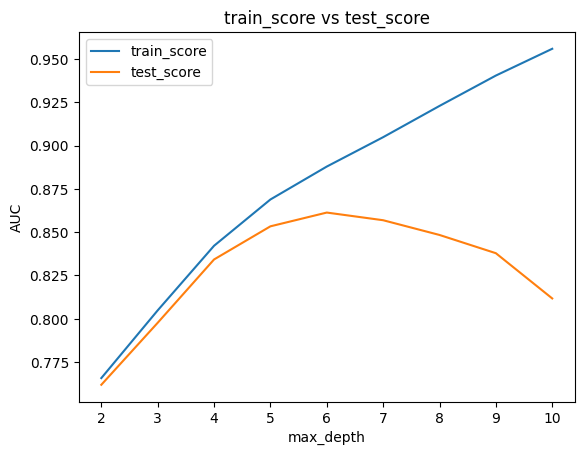

In [ ]:
# 学習に用いたデータを使って評価したスコアの描画
plt.plot([2,3,4,5,6,7,8,9,10], train_score, label="train_score")

# 学習には用いなかったデータを使って評価したスコアの描画
plt.plot([2,3,4,5,6,7,8,9,10], test_score, label="test_score")

# グラフにタイトルを追加
plt.title('train_score vs test_score')

# グラフのx軸に名前を追加
plt.xlabel('max_depth')

# グラフのy軸に名前を追加
plt.ylabel('AUC')

# 凡例の表示
plt.legend()

# グラフの表示
plt.show()

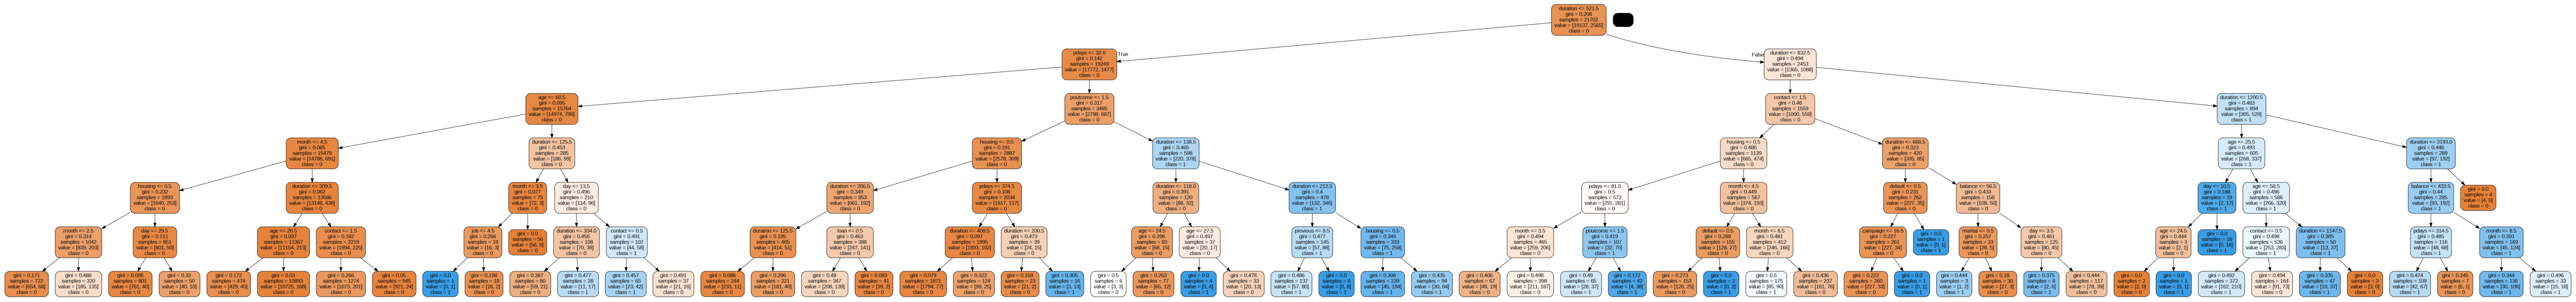

In [ ]:
# 決定木描画ライブラリのインポート
from sklearn.tree import export_graphviz

# 決定木グラフの出力
export_graphviz(gcv.best_estimator_, out_file="tree.dot", feature_names=train_X.columns, class_names=["0","1"], filled=True, rounded=True)

# 決定木グラフの表示
from PIL import Image
import pydotplus
import io
g = pydotplus.graph_from_dot_file(path="tree.dot")
gg = g.create_png()
img = io.BytesIO(gg)
img2 = Image.open(img)
plt.figure(figsize=(img2.width/100, img2.height/100), dpi=75)
plt.imshow(img2)
plt.axis("off")
plt.show()

In [ ]:
best_model = gcv.best_estimator_
test_y= [round(prob, 3) for prob in best_model.predict_proba(test)[:, 1]]

In [ ]:
y_test_series = pd.Series(test_y)
result_df = pd.concat([sample.iloc[:, 0],y_test_series], axis=1)
result_df.to_csv('/content/drive/MyDrive/signate/練習　銀行の顧客ターゲティング/submit.csv', header=False, index=False)
result_df.shape

(18083, 2)